In [1]:
# Evironment setup and imports

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde

from torchvision import datasets, transforms
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader, Subset

import timm
from functools import partial

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# DeiT-III Classes

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None,
                 attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(
            B, N, 3, self.num_heads, C // self.num_heads
        ).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None,
                 act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample."""
    def __init__(self, drop_prob=0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,)*(x.ndim-1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output

def trunc_normal_(tensor, mean=0., std=1.):
    # trivial init
    with torch.no_grad():
        return tensor.normal_(mean, std)

class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # shape [B, embed_dim, H_patch, W_patch]
        B, C, H, W = x.shape
        # flatten: [B, C, H*W] => transpose => [B, H*W, C]
        x = x.flatten(2).transpose(1, 2)
        return x  # [B, N, C]

class Block(nn.Module):
    """Basic Transformer Block (no layer-scale)"""
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                              qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class Layer_scale_init_Block(nn.Module):
    """Block w/ layer-scale initialization"""
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm, init_values=1e-4):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                              qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

class vit_models(nn.Module):
    """
    Vision Transformer with optional layer-scale blocks
    (based on your code).
    """
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        num_classes=1000,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.,
        norm_layer=nn.LayerNorm,
        global_pool=None,
        block_layers=Block,
        **kwargs
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))

        # DropPath rate
        dpr = [drop_path_rate for i in range(depth)]
        blocks = []
        for i in range(depth):
            blk = block_layers(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                norm_layer=norm_layer,
            )
            blocks.append(blk)
        self.blocks = nn.ModuleList(blocks)

        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        # shape => [B, N, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        # add pos embed
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed[:, : x.shape[1], :]

        # pass blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]  # cls token

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

# A small helper to create "deit_small_patch16_LS" as in your code:
def deit_small_patch16_LS(pretrained=False, img_size=224, **kwargs):
    model = vit_models(
        img_size=img_size,
        patch_size=16,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        block_layers=Layer_scale_init_Block,
        **kwargs
    )
    # If pretrained is True, you'd load a checkpoint here
    return model



In [ ]:
# Dinov2 + Retrained DeiT-III model

# -- DINOv2 (ViT-B14) from torch.hub
print("Loading DINOv2 (ViT-g14)...")
dino_model = torch.hub.load(
    'facebookresearch/dinov2',
    'dinov2_vitg14',
    pretrained=True,
    force_reload=True
)
dino_model.eval()
dino_model.to(device)
print(dino_model.n_blocks)

print("DINOv2 loaded.")

# -- Your custom DeiT-III
print("Loading your custom DeiT-III from checkpoint...")

deit_model = deit_small_patch16_LS(pretrained=False, img_size=224)
deit_model.to(device)
deit_model.eval()

checkpoint_path = 'checkpoints/source_checkpoints/checkpoint799.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model' in checkpoint:
        state_dict = checkpoint['model']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    pos_embed_key = "pos_embed"
    if pos_embed_key in state_dict:
        old_pos_embed = state_dict[pos_embed_key]
        desired_shape = (1, 197, 384)
        if old_pos_embed.shape != torch.Size(desired_shape):
            if list(old_pos_embed.shape) == [1,196,384] and desired_shape == (1,197,384):
                print("Adjusting pos_embed from [1,196,384] -> [1,197,384].")
                new_pos_embed = torch.zeros((1,197,384))
                new_pos_embed[:, 1:, :] = old_pos_embed
                state_dict[pos_embed_key] = new_pos_embed
                print("pos_embed successfully reshaped.")
            else:
                print("pos_embed shape mismatch not automatically fixable.")

    deit_model.load_state_dict(state_dict, strict=False)
    print(f"Checkpoint {checkpoint_path} loaded!")
else:
    print(f"WARNING: no checkpoint found at {checkpoint_path}. Using random initialization.")




Loading DINOv2 (ViT-B14)...


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/renan/.cache/torch/hub/main.zip
/home/renan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/renan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/renan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


40
DINOv2 loaded.
Loading your custom DeiT-III from checkpoint...


/tmp/ipykernel_154565/2025946435.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Adjusting pos_embed from [1,196,384] -> [1,197,384].
pos_embed successfully reshaped.
Checkpoint checkpoints/source_checkpoints/checkpoint799.pth loaded!


In [4]:
# Loading Imagenette

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

# dataset = datasets.Imagenette(
#     root="data_imagenette",  # Adjust if needed
#     download=True,
#     transform=transform
# )

# dataset = ImageFolder(
#     root="../imagenet/ILSVRC/Data/CLS-LOC/train",
#     transform=transform
# )
dataset = ImageFolder(
    root="imagenet/torchvision_ImageFolder/val",
    transform=transform
)

# select 1/10th 
subset = Subset(dataset, np.random.choice(len(dataset), len(dataset)//10, replace=False))
dataset = subset

data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=20)

print("Loaded Imagenet dataset.")


Loaded Imagenet dataset.


In [ ]:
# Helper Functions

# --- DINOv2 final patch embeddings (last layer) ---
def get_dino_final_patches(model, imgs):
    """
    DINOv2 (ViT-g/14) final embeddings: call get_intermediate_layers with n=12
    (since vitb14 has 12 blocks).
    If the returned tensor is 3D ([B, N, D]), return as is.
    If it is 4D ([B, D, H, W]), reshape to [B, H*W, D].
    """
    with torch.no_grad():
        feats = model.get_intermediate_layers(
            imgs,
            n=model.n_blocks,
            return_class_token=False,
            norm=False
        )
        x = feats[-1]
        if len(x.shape) == 3:
            return x
        elif len(x.shape) == 4:
            B, D, H, W = x.shape
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(B, H * W, D)
            return x
        else:
            raise ValueError("Unexpected shape for DINOv2 final patches: " + str(x.shape))

# --- DINOv2 initial patch embeddings (patch_embed) ---
def get_dino_initial_patches(model, imgs):
    """
    Right after patch embedding.
    If model.patch_embed returns a 4D tensor ([B, D, H, W]), reshape to [B, H*W, D].
    If it returns a 3D tensor ([B, N, D]), return as is.
    """
    with torch.no_grad():
        x = model.patch_embed(imgs)
        if len(x.shape) == 4:
            B, D, H, W = x.shape
            x = x.permute(0, 2, 3, 1).contiguous()
            x = x.view(B, H * W, D)
            return x
        elif len(x.shape) == 3:
            return x
        else:
            raise ValueError("Unexpected shape in patch_embed output: " + str(x.shape))

# --- DeiT-III final patch embeddings ---
def get_deit_final_patches(model, imgs):
    """
    For DeiT-III, replicate a forward pass to get final patch tokens (excluding the CLS token).
    """
    with torch.no_grad():
        x = model.patch_embed(imgs)
        B, N, D = x.shape

        # add cls token + pos embed
        cls_token = model.cls_token.expand(B, -1, -1)  # [B, 1, D]
        pos_embed = model.pos_embed[:, : (N+1), :]
        x = torch.cat([cls_token, x], dim=1)  # => [B, N+1, D]
        x = x + pos_embed

        for blk in model.blocks:
            x = blk(x)

        x = model.norm(x)  # [B, N+1, D]
        x = x[:, 1:, :]  # => [B, N, D]
    return x

# --- DeiT-III initial patch embeddings ---
def get_deit_initial_patches(model, imgs):
    """
    Right after patch_embed => [B, N, D].
    """
    with torch.no_grad():
        x = model.patch_embed(imgs)
    return x  # [B, N, D]

In [6]:
# Pass #1: Computing the final patch norm with 98% threshold


def gather_global_threshold(
    final_extraction_func,
    model,
    loader,
    percentile=0.98
):
    all_norms = []
    for (imgs, _) in tqdm(loader):
        imgs = imgs.to(device)
        final_embs = final_extraction_func(model, imgs)  # [B, N, D]
        norms = torch.norm(final_embs, dim=-1)  # [B, N]
        all_norms.append(norms.flatten().cpu())
    all_norms = torch.cat(all_norms, dim=0)
    threshold = torch.quantile(all_norms, percentile).item()
    return threshold

In [ ]:
# Pass #2: Label patches (artefact vs normal) by final score and measure cos in intital space

def compute_cosines_labelled_by_final(
    final_extraction_func,
    initial_extraction_func,
    model,
    loader,
    threshold,
    grid_size
):
    cos_artifact = []
    cos_normal = []
    neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    def valid_neighbors(r, c):
        for (dr, dc) in neighbor_offsets:
            rr, cc = r + dr, c + dc
            if 0 <= rr < grid_size and 0 <= cc < grid_size:
                yield (rr, cc)

    for (imgs, _) in tqdm(loader):
        imgs = imgs.to(device)
        final_embs = final_extraction_func(model, imgs)    # labeling
        initial_embs = initial_extraction_func(model, imgs)  # compute cosine similarity

        B, N, D = final_embs.shape
        norms = torch.norm(final_embs, dim=-1)  # [B, N]
        norms_2d = norms.view(B, grid_size, grid_size)

        init_2d = initial_embs.view(B, grid_size, grid_size, D)

        # for b in range(B):
        #     for r in range(grid_size):
        #         for c in range(grid_size):
        #             if norms_2d[b, r, c] > threshold:
        #                 target = cos_artifact
        #             else:
        #                 target = cos_normal

        #             v = init_2d[b, r, c]
        #             for (rr, cc) in valid_neighbors(r, c):
        #                 nb = init_2d[b, rr, cc]
        #                 sim = F.cosine_similarity(
        #                     v.unsqueeze(0),
        #                     nb.unsqueeze(0),
        #                     dim=1
        #                 )
        #                 target.append(sim.item())

        for dr, dc in neighbor_offsets:
            if dr == -1:
                # For upward neighbor, consider rows 1:H for main and 0:H-1 for neighbor.
                main = init_2d[:, 1:, :, :]       # [B, H-1, W, D]
                neighbor = init_2d[:, :-1, :, :]    # [B, H-1, W, D]
                mask = norms_2d[:, 1:, :] > threshold  # Label based on main patch norm.
            elif dr == 1:
                # Downward neighbor.
                main = init_2d[:, :-1, :, :]
                neighbor = init_2d[:, 1:, :, :]
                mask = norms_2d[:, :-1, :] > threshold
            elif dc == -1:
                # Left neighbor.
                main = init_2d[:, :, 1:, :]
                neighbor = init_2d[:, :, :-1, :]
                mask = norms_2d[:, :, 1:] > threshold
            elif dc == 1:
                # Right neighbor.
                main = init_2d[:, :, :-1, :]
                neighbor = init_2d[:, :, 1:, :]
                mask = norms_2d[:, :, :-1] > threshold
            
            # Compute cosine similarity in a vectorized fashion.
            similarity = F.cosine_similarity(main, neighbor, dim=-1)  # Shape matches mask.
            
            # Use the boolean mask to separate artifact vs. normal patches.
            artifact_sim = similarity[mask]
            normal_sim = similarity[~mask]
            cos_artifact.append(artifact_sim.cpu())
            cos_normal.append(normal_sim.cpu())

    return cos_artifact, cos_normal

def plot_density(cos_artifact, cos_normal, title):
    """
    Plot kernel density of cosine similarities.
    """
    cos_artifact = np.concatenate([np.array(x).ravel() for x in cos_artifact])
    cos_normal = np.concatenate([np.array(x).ravel() for x in cos_normal])

    kde_a = gaussian_kde(cos_artifact) if len(cos_artifact) > 1 else None
    kde_n = gaussian_kde(cos_normal) if len(cos_normal) > 1 else None

    x_range = np.linspace(0, 1, 400)
    plt.figure(figsize=(7/2, 5/2))

    if kde_n is not None:
        plt.plot(x_range, kde_n(x_range), label="Normal patches", color="blue")
    if kde_a is not None:
        plt.plot(x_range, kde_a(x_range), label="Artifact patches", color="orange")

    plt.title(title)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

=== DINOv2 (ViT-B14) Analysis ===
=== DeiT-III (Custom) Analysis ===
DeiT-III threshold @ 98% = 63.8545


100%|██████████| 313/313 [00:13<00:00, 22.58it/s]


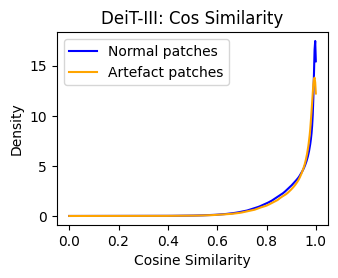

In [ ]:
# Main run

def main_analysis():
    # ------------------ DINOv2 (ViT-B14) ------------------ #
    print("=== DINOv2 (ViT-g14) Analysis ===")
    # Pass #1: final norm threshold
    dino_threshold = gather_global_threshold(
        final_extraction_func=get_dino_final_patches,
        model=dino_model,
        loader=data_loader,
        percentile=0.98
    )
    # dino_threshold = 150
    print(f"DINOv2 threshold @ 98% = {dino_threshold:.4f}")

    sample_imgs, _ = next(iter(data_loader))
    sample_final = get_dino_final_patches(dino_model, sample_imgs.to(device))
    dino_grid_size = int(sample_final.shape[1]**0.5)

    # Pass #2: measure cosine similarity in initial space
    dino_cos_artifact, dino_cos_normal = compute_cosines_labelled_by_final(
        final_extraction_func=get_dino_final_patches,
        initial_extraction_func=get_dino_initial_patches,
        model=dino_model,
        loader=data_loader,
        threshold=dino_threshold,
        grid_size=dino_grid_size
    )

    plot_density(dino_cos_artifact, dino_cos_normal,
                 title="DINOv2 (ViT-g14): Cos Similarity")

    # ------------------ DeiT-III (Custom) ------------------ #
    print("=== DeiT-III (Custom) Analysis ===")
    # Pass #1: final norm threshold
    deit_threshold = gather_global_threshold(
        final_extraction_func=get_deit_final_patches,
        model=deit_model,
        loader=data_loader,
        percentile=0.98
    )

    print(f"DeiT-III threshold @ 98% = {deit_threshold:.4f}")

    sample_final_deit = get_deit_final_patches(deit_model, sample_imgs.to(device))
    deit_grid_size = int(sample_final_deit.shape[1]**0.5)

    # Pass #2: measure cosine similarity in initial space
    deit_cos_artifact, deit_cos_normal = compute_cosines_labelled_by_final(
        final_extraction_func=get_deit_final_patches,
        initial_extraction_func=get_deit_initial_patches,
        model=deit_model,
        loader=data_loader,
        threshold=deit_threshold,
        grid_size=deit_grid_size
    )
    plot_density(deit_cos_artifact, deit_cos_normal,
                 title="DeiT-III: Cos Similarity")

if __name__ == "__main__":
    main_analysis()

In [ ]:
# PASS #1: Compute final patch norm => 99.5% threshold

def gather_global_threshold(
    final_extraction_func,
    model,
    loader,
    percentile=0.995
):
    all_norms = []
    for (imgs, _) in loader:
        imgs = imgs.to(device)
        final_embs = final_extraction_func(model, imgs)  # [B, N, D]
        norms = torch.norm(final_embs, dim=-1)  # [B, N]
        all_norms.append(norms.flatten().cpu())
    all_norms = torch.cat(all_norms, dim=0)
    threshold = torch.quantile(all_norms, percentile).item()
    return threshold

In [ ]:
# Run for DeiT-III with 99.5% thershold

def new_analysis():
    # ------------------ DeiT-III (Custom) ------------------ #
    print("=== DeiT-III (Custom) Analysis ===")
    # Pass #1: final norm threshold
    deit_threshold = gather_global_threshold(
        final_extraction_func=get_deit_final_patches,
        model=deit_model,
        loader=data_loader,
        percentile=0.995
    )
    print(f"DeiT-III threshold @ 99.5% = {deit_threshold:.4f}")

    # Determine grid_size from a sample
    sample_imgs, _ = next(iter(data_loader))
    sample_final_deit = get_deit_final_patches(deit_model, sample_imgs.to(device))
    deit_grid_size = int(sample_final_deit.shape[1]**0.5)

    # Pass #2: measure cosine similarity in the initial space
    deit_cos_artifact, deit_cos_normal = compute_cosines_labelled_by_final(
        final_extraction_func=get_deit_final_patches,
        initial_extraction_func=get_deit_initial_patches,
        model=deit_model,
        loader=data_loader,
        threshold=deit_threshold,
        grid_size=deit_grid_size
    )
    plot_density(deit_cos_artifact, deit_cos_normal,
                 title="DeiT-III with 99.5% threshold")

if __name__ == "__main__":
    new_analysis()